# Biophysical Variable Prediction in Scikit-Learn and Keras using PROSAIL Sentinel 2 Band Simulated Database
---

## Introduction
---

### Background
*Similar background to ALR paper*

### Objectives
The main objective of this paper is to compare the performance of SL2P(D) against the performance of a purely linear model which performs variable selection on the input bands, as well as the performance of the same linear model with the addition of a neural network which performs regression on the features selected by the linear model. In this case the feature selection will be performed by the least angle regression algorithm (Efron et al., 2002) provided by scikit-learn.

Specifically performance will be measured using the root mean squared error of each model as well as the absolute error in the model with respect to the specific true value of the response variables.

## Methodology
---

### Methods
Three methods were tested on the global PROSAIL dataset with 41472 samples simulated from various different biomes to estimate LAI, FCOVER, and FAPAR.
* SL2P
* LARS Regression
* LARS Regression + Keras (Tensorflow) Shallow Neural Network

The PROSAIL simulation generates Sentinel 2 bands:

| Band | Central Wavelength | Description | Resolution | 
|---|---|---|---|
| B3 | 560nm | green | 10m |
| B4 | 665nm | red | 10m |
| B5 | 705nm | VNIR | 20m res |
| B6 | 740nm | VNIR | 20m res |
| B7 | 783nm | VNIR | 20m res |
| B8A | 865nm | VNIR | 20m res |
| B11 | 1610nm | SWIR | 20m res |
| B12 | 2190nm | SWIR | 20m res |

*SL2P description* + `code`

In the script below the methodology used for LARS and the shallow neural network in Keras will be described further.

In [14]:
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy
import pandas
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import tensorflow

In [15]:
matlabData = sio.loadmat(file_name='data/s2_sl2p_weiss_or_prosail_inout.mat', variable_names=['Input', 'Output'])

In [16]:
inputDF = pandas.DataFrame(data=matlabData['Input']['Rho_Toc'][0][0])
inputAngles = pandas.DataFrame(data=matlabData['Input']['Angles'][0][0])

inputDF = pandas.concat([inputDF, inputAngles], axis=1, join='outer', ignore_index=True)
inputDF.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3']

LAI = pandas.Series(data=matlabData['Output']['LAI'][0][0].flatten())
FAPAR = pandas.Series(data=matlabData['Output']['FAPAR'][0][0].flatten())
FCOVER = pandas.Series(data=matlabData['Output']['FCOVER'][0][0].flatten())

outputCSV = pandas.concat([inputDF, LAI, FAPAR, FCOVER], axis=1, join='outer')
outputCSV['latitude'] = 0
outputCSV['longitude'] = 0
outputCSV.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3', 
                     'LAI', 'FAPAR', 'FCOVER', 'latitude', 'longitude']
outputCSV

,B3,B4,B5,B6,B7,B8a,B11,B12,A1,A2,A3,LAI,FAPAR,FCOVER,latitude,longitude
0,0.048953,0.030271,0.073742,0.294630,0.419698,0.436037,0.121603,0.043615,0.994435,0.853211,0.994632,6.014594,0.870412,0.875424,0,0
1,0.053655,0.029552,0.074523,0.383288,0.566787,0.597187,0.180981,0.054689,0.974949,0.899428,-0.974783,5.752335,0.957268,0.971936,0,0
2,0.075767,0.092849,0.144840,0.267414,0.306598,0.321708,0.254556,0.145838,0.970282,0.901471,0.982456,0.746137,0.386350,0.394260,0,0
3,0.071742,0.031115,0.094643,0.303518,0.383710,0.391068,0.118468,0.047038,0.987971,0.865112,-0.997234,5.374681,0.819419,0.830017,0,0
4,0.100043,0.028230,0.130998,0.442701,0.560120,0.563746,0.182785,0.062757,0.961521,0.385027,0.490117,5.467322,0.899630,0.927706,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41467,0.091781,0.028950,0.124602,0.420813,0.528081,0.544847,0.122709,0.032790,0.979430,0.704338,0.746313,4.951841,0.922245,0.949148,0,0
41468,0.046467,0.034942,0.069040,0.229278,0.308859,0.321834,0.126807,0.071680,0.994707,0.654700,-0.672963,4.453112,0.717015,0.714964,0,0
41469,0.045621,0.027923,0.067862,0.307144,0.445989,0.474847,0.162763,0.055750,0.999777,0.576598,-0.587336,4.579922,0.861480,0.871602,0,0
41470,0.053039,0.037354,0.081990,0.340293,0.506438,0.528001,0.190817,0.076028,0.988945,0.729268,0.771352,5.502935,0.879030,0.882815,0,0


In [17]:
outputCSV.to_csv(path_or_buf=r'rawFeatures.csv')

In [18]:
inputDF_centred = inputDF - inputDF.mean()
inputDF_normed = inputDF_centred * inputDF_centred.pow(2).sum().pow(-0.5)

LAI_mean = LAI.mean()
FAPAR_mean = FAPAR.mean()
FCOVER_mean = FCOVER.mean()

LAI_centred = LAI.subtract(LAI_mean)
FAPAR_centred = FAPAR.subtract(FAPAR_mean)
FCOVER_centred = FCOVER.subtract(FCOVER_mean)

outputCSV_scaled = pandas.concat([inputDF_normed, LAI_centred, FAPAR_centred, FCOVER_centred], axis=1, join='outer')
outputCSV_scaled['latitude'] = 0
outputCSV_scaled['longitude'] = 0
outputCSV_scaled.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3', 
                     'LAI', 'FAPAR', 'FCOVER', 'latitude', 'longitude']
outputCSV_scaled

,B3,B4,B5,B6,B7,B8a,B11,B12,A1,A2,A3,LAI,FAPAR,FCOVER,latitude,longitude
0,-0.004782,-0.003073,-0.004367,-0.000890,0.000502,0.000372,-0.006157,-0.004899,0.004487,0.004357,0.006255,2.730060,0.197899,0.196068,0,0
1,-0.003899,-0.003175,-0.004265,0.003712,0.005732,0.006026,-0.001843,-0.004107,-0.003168,0.005860,-0.006390,2.467801,0.284755,0.292580,0,0
2,0.000253,0.005743,0.004929,-0.002303,-0.003520,-0.003640,0.003502,0.002413,-0.005001,0.005927,0.006177,-2.538397,-0.286164,-0.285096,0,0
3,-0.000503,-0.002954,-0.001634,-0.000429,-0.000778,-0.001206,-0.006385,-0.004654,0.001948,0.004744,-0.006534,2.090147,0.146906,0.150661,0,0
4,0.004810,-0.003361,0.003119,0.006796,0.005495,0.004853,-0.001712,-0.003530,-0.008443,-0.010873,0.003016,2.182788,0.227116,0.248350,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41467,0.003259,-0.003259,0.002283,0.005660,0.004356,0.004190,-0.006077,-0.005673,-0.001407,-0.000486,0.004660,1.667307,0.249732,0.269792,0,0
41468,-0.005248,-0.002415,-0.004982,-0.004283,-0.003439,-0.003636,-0.005779,-0.002892,0.004594,-0.002100,-0.004452,1.168578,0.044502,0.035608,0,0
41469,-0.005407,-0.003404,-0.005136,-0.000241,0.001437,0.001734,-0.003167,-0.004031,0.006586,-0.004641,-0.003902,1.295389,0.188966,0.192247,0,0
41470,-0.004014,-0.002075,-0.003288,0.001480,0.003586,0.003599,-0.001129,-0.002581,0.002330,0.000325,0.004821,2.218401,0.206517,0.203459,0,0


In [19]:
outputCSV_scaled.to_csv(path_or_buf=r'scaledFeatures.csv')

In [20]:
LAImodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
LAImodel = LAImodel.fit(inputDF, LAI)

FAPARmodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
FAPARmodel = FAPARmodel.fit(inputDF, FAPAR)

FCOVERmodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
FCOVERmodel = FCOVERmodel.fit(inputDF, FCOVER)

In [21]:
LAI_predicted = pandas.Series(LAImodel.predict(inputDF))
FAPAR_predicted = pandas.Series(FAPARmodel.predict(inputDF))
FCOVER_predicted = pandas.Series(FCOVERmodel.predict(inputDF))

In [22]:
LAI_RMSE = sklearn.metrics.mean_squared_error(LAI, LAI_predicted, squared=False)
FAPAR_RMSE = sklearn.metrics.mean_squared_error(FAPAR, FAPAR_predicted, squared=False)
FCOVER_RMSE = sklearn.metrics.mean_squared_error(FCOVER, FCOVER_predicted, squared=False)

In [23]:
print('LAI Coefficient Path - RMSE: {}'.format(LAI_RMSE))
pandas.DataFrame(LAImodel.coef_path_)

LAI Coefficient Path - RMSE: 5.11933171132503


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,190.775037,233.774108
1,0.0,0.000000,0.000000,-28.130473,17.592608,250.937481,347.098907,805.275005,1226.371394,2110.594711,3085.328223,3305.180013
2,0.0,0.000000,0.000000,0.000000,-55.195770,-169.501697,-215.686462,-435.143220,-933.815621,-2204.784551,-3716.680024,-4057.638575
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1008.493250,4006.333721,7062.576687,7751.866169
4,0.0,65.151139,99.425893,181.077028,226.586317,301.028420,260.901508,44.897631,-1161.199720,-6437.704483,-11965.904402,-13212.479206
5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,70.114309,445.374064,891.319735,3814.177640,6894.407750,7588.954053
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-31.487267,-88.828277,-371.403624,-558.162885,-600.348570
7,0.0,0.000000,-34.274754,-94.992055,-110.249060,-225.224774,-274.611374,-479.158511,-508.306605,-362.598916,-350.305267,-347.448911
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.382167
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
print('FAPAR Coefficient Path - RMSE: {}'.format(FAPAR_RMSE))
pandas.DataFrame(FAPARmodel.coef_path_)

FAPAR Coefficient Path - RMSE: 0.05440925928136116


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.336603,1.632704,1.697051,2.236579
1,0.0,0.000000,-6.460423,-10.649835,-9.953746,-9.156543,-8.976348,-8.886272,-8.269247,-6.702619,-6.361850,-3.503064
2,0.0,0.000000,0.000000,0.000000,-0.804852,-2.827408,-2.771695,-2.743881,-4.199070,-6.889422,-7.474488,-12.381304
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.848944,7.120985,17.788831
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-9.876196,-14.817414,-23.580760,-34.753832,-37.183271,-57.559117
5,0.0,14.825946,21.286369,35.591841,36.255058,42.545374,52.821895,57.963616,66.696395,73.195965,74.609149,86.462497
6,0.0,0.000000,0.000000,0.000000,0.000000,-8.297515,-9.251976,-9.729357,-9.775492,-10.309729,-10.426033,-11.401420
7,0.0,0.000000,0.000000,-11.224459,-11.478877,-3.192868,-2.683851,-2.429124,-2.956552,-2.627116,-2.555326,-1.953906
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004795,0.044879
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.021876,-0.059025,-0.082388,-0.087402,-0.130891


In [25]:
print('FCOVER Coefficient Path - RMSE: {}'.format(FCOVER_RMSE))
pandas.DataFrame(FCOVERmodel.coef_path_)

FCOVER Coefficient Path - RMSE: 0.050418221590163535


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.191658,0.700360,1.062283,1.092457,1.501445
1,0.0,0.000000,-7.904331,-12.342568,-13.436651,-13.280295,-13.138369,-13.133292,-12.898456,-10.983573,-10.823839,-8.656743
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.553834,-3.842240,-4.116468,-7.836068
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.149141,7.745298,15.832033
4,0.0,0.000000,0.000000,0.000000,0.000000,-6.539179,-12.481904,-19.020812,-22.356078,-36.012878,-37.151790,-52.597653
5,0.0,13.990779,21.895110,37.050238,42.096231,48.911396,55.105170,61.801048,65.124680,73.069078,73.731653,82.717056
6,0.0,0.000000,0.000000,0.000000,-7.918294,-8.538703,-9.102364,-9.675361,-9.692920,-10.345916,-10.400369,-11.139759
7,0.0,0.000000,0.000000,-11.891123,-3.870849,-3.547683,-3.253895,-2.989977,-3.190712,-2.788044,-2.754502,-2.298597
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030386
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.026384,-0.054704,-0.068843,-0.097400,-0.099862,-0.132829


In [26]:
LAImodel = sklearn.linear_model.Lars(n_nonzero_coefs=4)
LAImodel = LAImodel.fit(inputDF, LAI)

FAPARmodel = sklearn.linear_model.Lars(n_nonzero_coefs=3)
FAPARmodel = FAPARmodel.fit(inputDF, FAPAR)

FCOVERmodel = sklearn.linear_model.Lars(n_nonzero_coefs=3)
FCOVERmodel = FCOVERmodel.fit(inputDF, FCOVER)

In [27]:
LAI_predicted = pandas.Series(LAImodel.predict(inputDF))
FAPAR_predicted = pandas.Series(FAPARmodel.predict(inputDF))
FCOVER_predicted = pandas.Series(FCOVERmodel.predict(inputDF))

In [28]:
LAI_features = numpy.nonzero(LAImodel.coef_)[0]
FAPAR_features = numpy.nonzero(FAPARmodel.coef_)[0]
FCOVER_features = numpy.nonzero(FCOVERmodel.coef_)[0]

LAI_features = inputDF.columns[LAI_features]
FAPAR_features = inputDF.columns[FAPAR_features]
FCOVER_features = inputDF.columns[FCOVER_features]

In [29]:
LAI_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(inputDF[LAI_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])
LAI_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])


FAPAR_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(inputDF[FAPAR_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])
FAPAR_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])


FCOVER_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(inputDF[FCOVER_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])
FCOVER_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

In [30]:
LAI_model.fit(x = inputDF[LAI_features], y = LAI, epochs = 100, validation_split = 0.2)
FAPAR_model.fit(x = inputDF[FAPAR_features], y = FAPAR, epochs = 20, validation_split = 0.2)
FCOVER_model.fit(x = inputDF[FCOVER_features], y = FCOVER, epochs = 20, validation_split = 0.2)

Train on 33177 samples, validate on 8295 samples
Epoch 1/100
33177/33177 [==============================] - 3s 75us/sample - loss: 5.1628 - mse: 5.1628 - mae: 1.8074 - val_loss: 4.7559 - val_mse: 4.7559 - val_mae: 1.7617
Epoch 2/100
33177/33177 [==============================] - 1s 41us/sample - loss: 4.1706 - mse: 4.1706 - mae: 1.6537 - val_loss: 3.8052 - val_mse: 3.8052 - val_mae: 1.5631
Epoch 3/100
33177/33177 [==============================] - 2s 46us/sample - loss: 2.5677 - mse: 2.5677 - mae: 1.2510 - val_loss: 1.7874 - val_mse: 1.7874 - val_mae: 0.9977
Epoch 4/100
33177/33177 [==============================] - 1s 38us/sample - loss: 1.3483 - mse: 1.3483 - mae: 0.8830 - val_loss: 1.3101 - val_mse: 1.3101 - val_mae: 0.8704
Epoch 5/100
33177/33177 [==============================] - 1s 45us/sample - loss: 1.1526 - mse: 1.1526 - mae: 0.8294 - val_loss: 1.1914 - val_mse: 1.1914 - val_mae: 0.8373
Epoch 6/100
33177/33177 [==============================] - 1s 37us/sample - loss: 1.0760 - 

In [31]:
LAI_predictions = pandas.Series(LAI_model.predict(inputDF[LAI_features]).flatten())
FAPAR_predictions = pandas.Series(FAPAR_model.predict(inputDF[FAPAR_features]).flatten())
FCOVER_predictions = pandas.Series(FCOVER_model.predict(inputDF[FCOVER_features]).flatten())

In [36]:
xy_skl_LAI = numpy.vstack([LAI, LAI_predicted])
xy_tf_LAI = numpy.vstack([LAI, LAI_predictions])
xy_skl_FAPAR = numpy.vstack([FAPAR, FAPAR_predicted])
xy_tf_FAPAR = numpy.vstack([FAPAR, FAPAR_predictions])
xy_skl_FCOVER = numpy.vstack([FCOVER, FCOVER_predicted])
xy_tf_FCOVER = numpy.vstack([FCOVER, FCOVER_predictions])

In [37]:
z_skl_LAI = scipy.stats.gaussian_kde(xy_skl_LAI)(xy_skl_LAI)
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)
z_skl_FAPAR = scipy.stats.gaussian_kde(xy_skl_FAPAR)(xy_skl_FAPAR)
z_tf_FAPAR = scipy.stats.gaussian_kde(xy_tf_FAPAR)(xy_tf_FAPAR)
z_skl_FCOVER = scipy.stats.gaussian_kde(xy_skl_FCOVER)(xy_skl_FCOVER)
z_tf_FCOVER = scipy.stats.gaussian_kde(xy_tf_FCOVER)(xy_tf_FCOVER)

In [39]:
idx_skl_LAI = z_skl_LAI.argsort()
idx_tf_LAI = z_tf_LAI.argsort()
idx_skl_FAPAR = z_skl_FAPAR.argsort()
idx_tf_FAPAR = z_tf_FAPAR.argsort()
idx_skl_FCOVER = z_skl_FCOVER.argsort()
idx_tf_FCOVER = z_tf_FCOVER.argsort()

In [40]:
x_skl_LAI = LAI[idx_skl_LAI]
x_tf_LAI = LAI[idx_tf_LAI]
x_skl_FAPAR = FAPAR[idx_skl_FAPAR]
x_tf_FAPAR = FAPAR[idx_tf_FAPAR]
x_skl_FCOVER = FCOVER[idx_skl_FCOVER]
x_tf_FCOVER = FCOVER[idx_tf_FCOVER]

In [41]:
y_skl_LAI = LAI_predicted[idx_skl_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]
y_skl_FAPAR = FAPAR_predicted[idx_skl_FAPAR]
y_tf_FAPAR = FAPAR_predictions[idx_tf_FAPAR]
y_skl_FCOVER = FCOVER_predicted[idx_skl_FCOVER]
y_tf_FCOVER = FCOVER_predictions[idx_tf_FCOVER]

In [42]:
z_skl_LAI = z_skl_LAI[idx_skl_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]
z_skl_FAPAR = z_skl_FAPAR[idx_skl_FAPAR]
z_tf_FAPAR = z_tf_FAPAR[idx_tf_FAPAR]
z_skl_FCOVER = z_skl_FCOVER[idx_skl_FCOVER]
z_tf_FCOVER = z_tf_FCOVER[idx_tf_FCOVER]

In [43]:
rmse_skl_LAI = sklearn.metrics.mean_squared_error(x_skl_LAI, y_skl_LAI, squared=False)
rmse_tf_LAI = sklearn.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)
rmse_skl_FAPAR = sklearn.metrics.mean_squared_error(x_skl_FAPAR, y_skl_FAPAR, squared=False)
rmse_tf_FAPAR = sklearn.metrics.mean_squared_error(x_tf_FAPAR, y_tf_FAPAR, squared=False)
rmse_skl_FCOVER = sklearn.metrics.mean_squared_error(x_skl_FCOVER, y_skl_FCOVER, squared=False)
rmse_tf_FCOVER = sklearn.metrics.mean_squared_error(x_tf_FCOVER, y_tf_FCOVER, squared=False)

In [44]:
a_skl_LAI = numpy.linspace(0, 6, 1000)
a_tf_LAI = numpy.linspace(0, 10, 1000)
a_skl_FAPAR = numpy.linspace(0, 1, 1000)
a_tf_FAPAR = numpy.linspace(0, 1, 1000)
a_skl_FCOVER = numpy.linspace(0, 1, 1000)
a_tf_FCOVER = numpy.linspace(0, 1, 1000)

Text(0.5, 1.0, 'NNet FCOVER - RMSE: 0.03204787150911458')

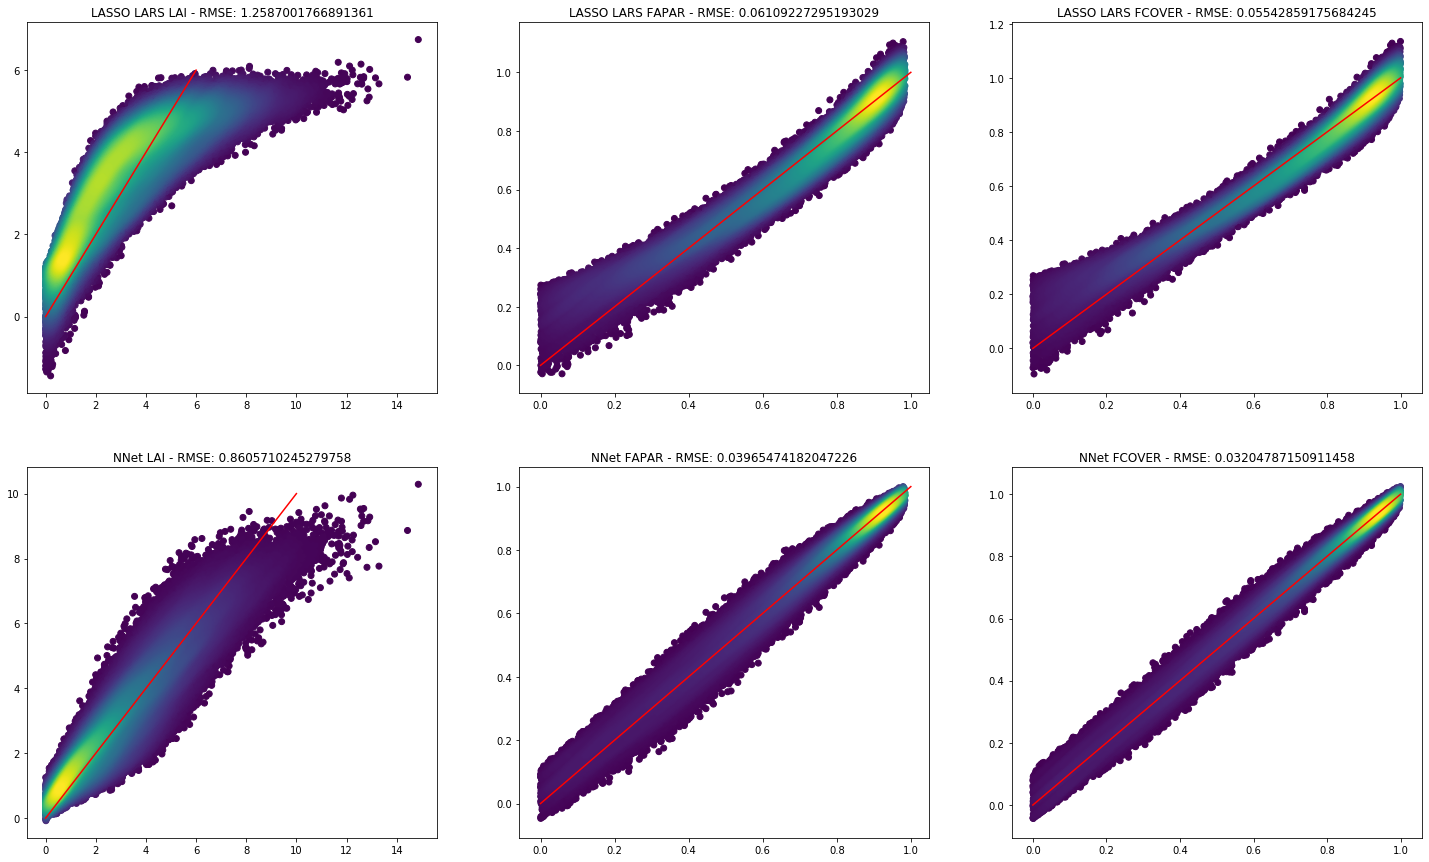

In [45]:
fig, ax = plt.subplots(2, 3, figsize=(25,15))


ax[0,0].scatter(x_skl_LAI, y_skl_LAI, c=z_skl_LAI)
ax[0,0].plot(a_skl_LAI, a_skl_LAI, c='r')
ax[0,0].set_title('LASSO LARS LAI - RMSE: {}'.format(rmse_skl_LAI))


ax[1,0].scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax[1,0].plot(a_tf_LAI, a_tf_LAI, c='r')
ax[1,0].set_title('NNet LAI - RMSE: {}'.format(rmse_tf_LAI))


ax[0,1].scatter(x_skl_FAPAR, y_skl_FAPAR, c=z_skl_FAPAR)
ax[0,1].plot(a_skl_FAPAR, a_skl_FAPAR, c='r')
ax[0,1].set_title('LASSO LARS FAPAR - RMSE: {}'.format(rmse_skl_FAPAR))


ax[1,1].scatter(x_tf_FAPAR, y_tf_FAPAR, c=z_tf_FAPAR)
ax[1,1].plot(a_tf_FAPAR, a_tf_FAPAR, c='r')
ax[1,1].set_title('NNet FAPAR - RMSE: {}'.format(rmse_tf_FAPAR))


ax[0,2].scatter(x_skl_FCOVER, y_skl_FCOVER, c=z_skl_FCOVER)
ax[0,2].plot(a_skl_FCOVER, a_skl_FCOVER, c='r')
ax[0,2].set_title('LASSO LARS FCOVER - RMSE: {}'.format(rmse_skl_FCOVER))


ax[1,2].scatter(x_tf_FCOVER, y_tf_FCOVER, c=z_tf_FCOVER)
ax[1,2].plot(a_tf_FCOVER, a_tf_FCOVER, c='r')
ax[1,2].set_title('NNet FCOVER - RMSE: {}'.format(rmse_tf_FCOVER))

In [46]:
import ee
ee.Initialize()

In [47]:
def EE_LARS_Regression(assetName, features, response, maxSamples, n_nonzero):
        
    inputCSV = ee.FeatureCollection(assetName)
    inputCSV = inputCSV.toList(count=maxSamples)
    
    def extractBands(feature):
        feature = ee.Feature(feature)
        return feature.toArray(properties=features).toList()

    def extractVI(feature):
        feature = ee.Feature(feature)
        return feature.toArray(properties=[response]).toList()
    
    inputList = inputCSV.map(extractBands)
    outputList = inputCSV.map(extractVI)
    
    X = ee.Array(inputList)
    y = ee.Array(outputList)
    
    n = X.length().get([0])
    m = X.length().get([1])
    
    
    def centre(output):
        output = ee.Array(output)
        mean = output.reduce(ee.Reducer.mean(), [0]).get([0,0])
        return output.subtract(mean)
        
    def normalize(inputs):
        inputs = ee.Array(inputs)
        
        inputMeans = inputs.reduce(ee.Reducer.mean(), [0])
        inputMeans = inputMeans.repeat(0, n)
        inputs = inputs.subtract(inputMeans)
        inputs = inputs.pow(2).reduce(ee.Reducer.sum(), [0]).pow(-0.5).repeat(0,n).multiply(inputs)
        
        return inputs
    
    X = normalize(X)
    y = centre(y)
    
    def LARSregression(iteration, inputs):
        inputs = ee.Dictionary(inputs)
        prediction = inputs.getArray('prediction')
        coeff_arr = inputs.getArray('coeff_arr')
    
        c = X.matrixTranspose().matrixMultiply(y.subtract(prediction))
        c_abs = c.abs()
        C_max = c_abs.get(c_abs.argmax())

        maxLocs = c_abs.gte(C_max.subtract(0.00001))
        signs = c.divide(c_abs)

        signs_j = maxLocs.multiply(signs).matrixTranspose()
        signs_jc = signs_j.abs().subtract(1).multiply(-1)
        
        A = ee.List(ee.Array([ee.List.sequence(0, m.subtract(1))]).mask(signs_j).toList().get(0))
        A_c = ee.List(ee.Array([ee.List.sequence(0, m.subtract(1))]).mask(signs_jc).toList().get(0))

        signMatrix_j = signs_j.repeat(0, n)

        X_A = X.multiply(signMatrix_j).mask(signs_j)
        j = X_A.length().get([1])
        
        G_A = X_A.matrixTranspose().matrixMultiply(X_A)

        V1_A = ee.Array(ee.List.repeat([1], j))

        G_Ai = G_A.matrixInverse()

        A_A = V1_A.matrixTranspose().matrixMultiply(G_Ai).matrixMultiply(V1_A).get([0,0]).pow(-0.5)

        w_A = G_Ai.matrixMultiply(V1_A).multiply(A_A)

        u_A = X_A.matrixMultiply(w_A)

        a = X.matrixTranspose().matrixMultiply(u_A)

        def computeGammaRRay(index_j):
            minus_j = C_max.subtract(c.get([index_j, 0])).divide(A_A.subtract(a.get([index_j, 0])))
            plus_j = C_max.add(c.get([index_j, 0])).divide(A_A.add(a.get([index_j, 0])))

            gammaRRay = ee.Array([minus_j, plus_j]);
            gammaRRay = gammaRRay.mask(gammaRRay.gte(0))
            gammaRRay = gammaRRay.multiply(-1)

            return gammaRRay.get(gammaRRay.argmax())

        gammaRRay = ee.Array([A_c.map(computeGammaRRay)])
        gamma = gammaRRay.get(gammaRRay.argmax()).multiply(-1)

        prediction = prediction.add(u_A.multiply(gamma))
        coefficients = X.matrixSolve(prediction)

        def setZero(num):
            num = ee.Number(num)
            return ee.Algorithms.If(num.abs().lt(0.0000000001), [0], [num])

        coefficients = ee.Array(ee.List(coefficients.matrixTranspose().toList().get(0)).map(setZero))

        coeff_arr = ee.Array.cat([coeff_arr, coefficients], axis=1)

        outputs = ee.Dictionary({'prediction':prediction, 'coeff_arr':coeff_arr})

        return outputs
    
    
    numIterations = ee.List.sequence(1, n_nonzero)
    prediction = ee.Array(ee.List.repeat([0], n))
    coeff_arr = ee.Array(ee.List.repeat([0], m))
    initial = ee.Dictionary({'prediction':prediction, 'coeff_arr':coeff_arr})

    finalOutputs = numIterations.iterate(LARSregression, initial)
    finalOutputs = ee.Dictionary(finalOutputs)
    finalPrediction = finalOutputs.getArray('prediction')

    coeff_arr = finalOutputs.getArray('coeff_arr')
    coeff_arr = coeff_arr.getInfo()
    coeff_arr = numpy.asarray(coeff_arr)
    
    return coeff_arr

In [48]:
LAI_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures', 
                              ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'], 
                              'LAI', 
                              50000, 
                              10)

EEException: Collection.loadTable: Collection asset 'users/ccrs2fy2020/rawFeatures' not found.

In [ ]:
FAPAR_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures',
                                ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'],
                                'FAPAR', 
                                50000, 
                                10)

In [ ]:
FCOVER_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures', 
                                 ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'],
                                 'FCOVER', 
                                 50000, 
                                 10)

In [ ]:
LAI_coef = pandas.DataFrame(LAI_coef)
FAPAR_coef = pandas.DataFrame(FAPAR_coef)
FCOVER_coef = pandas.DataFrame(FCOVER_coef)

In [ ]:
LAI_coef

In [ ]:
FAPAR_coef

In [ ]:
FCOVER_coef